In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
import pandas as pd
import time
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sksurv.datasets import load_flchain, load_gbsg2
from sksurv.functions import StepFunction
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder, encode_categorical
from sksurv.util import Surv

import scipy.optimize as opt

set_config(display="text")  # displays text representation of estimators
plt.rcParams["figure.figsize"] = [7.2, 4.8]

In [2]:
def generate_marker(n_samples, m,  baseline_hazard, rnd, time_points=None):
    
    # create synthetic risk score
    X = np.array(rnd.randn(n_samples, m))
    hazard_ratio = np.expand_dims(np.array(rnd.uniform(size=m)), axis=0)

    # create linear model
    logits = np.dot(X, np.log(hazard_ratio).T)

    # draw actual survival times from exponential distribution,
    # refer to Bender et al. (2005), https://doi.org/10.1002/sim.2059
    u = rnd.uniform(size=n_samples)
    risk_scores = np.squeeze(logits)
    time_event = -np.log(u) / (baseline_hazard * np.exp(risk_scores))

    # compute the actual concordance in the absence of censoring
    actual = concordance_index_censored(np.ones(n_samples, dtype=bool), time_event, risk_scores)

    # Calculate baseline AUC on uncensored data
    y_uncensored = np.array([(True, t) for t in time_event], 
                  dtype=[('event', bool), ('time', float)])
    
    baseline_auc, baseline_mean_auc = cumulative_dynamic_auc(
        y_uncensored, y_uncensored, risk_scores, time_points
    )

    # calculate other actual metrics here as well

    return X, time_event, actual[0], hazard_ratio, risk_scores, baseline_auc, baseline_mean_auc, time_points # risk scores, time events, actual concordance, weights

In [3]:
def generate_survival_data(n_samples, m, baseline_hazard, percentage_cens, rnd, time_points=None, retry=True, evaluate_auc=True):
                 
    X, time_event, actual_c, hazard_ratio, risk_scores, baseline_auc, baseline_mean_auc, eval_time_points = generate_marker(
        n_samples, m, baseline_hazard, rnd, time_points)

    def get_observed_time(x): # this censors certain time events
        rnd_cens = rnd
        # draw censoring times
        time_censor = rnd_cens.uniform(high=x, size=n_samples)
        event = time_event < time_censor
        time = np.where(event, time_event, time_censor)
        return event, time # returns bool array of if event occured or not/censored, and the time it occured/ was censored

    def censoring_amount(x): # finds optimal time event censoring will be as close to desired censored amount
        event, _ = get_observed_time(x)
        cens = 1.0 - event.sum() / event.shape[0]
        return (cens - percentage_cens) ** 2

    # search for upper limit to obtain the desired censoring amount
    res = opt.minimize_scalar(censoring_amount, method="bounded", bounds=(0, time_event.max()))

    if ( np.abs(res.fun) > 2.0/n_samples and retry): # check for convergence
        return generate_survival_data(n_samples, m, baseline_hazard, percentage_cens, rnd=rnd, retry=False, time_points=time_points)
    elif (np.abs(res.fun) > 2.0/n_samples and not retry):
        converged = False
    else:
        converged = True

    # compute observed time
    event, time = get_observed_time(res.x) # now that we have the optimal time event, we use that to get all the events and times

    # upper time limit such that the probability of being censored is non-zero for `t > tau`
    # we are finding the latest observed event time, and only keeping those events where time is < tau to decrease biases
    tau = time[event].max()
    y = Surv.from_arrays(event=event, time=time)
    mask = time < tau
    X_test = X[mask]
    y_test = y[mask]

    return X_test, y_test, y, actual_c, converged, hazard_ratio, risk_scores[mask], baseline_mean_auc, eval_time_points


In [4]:
def simulation(n_samples, m, n_repeats=100, time_points=10):

    start_time = time.time()

    rnd = np.random.RandomState(42) 
    
    measures = (
        "censoring",
        "Actual C",
        "Harrel's C",
        "Uno's C",
        "Baseline AUC",
        "AUC",
        "Brier",
    )
    results = {
        "cph": {"mean": [], "std": [], "censoring": []},
        "rsf": {"mean": [], "std": [], "censoring": []},
        "gbsa": {"mean": [], "std": [], "censoring": []}
    }

    # iterate over different amount of censoring -  0, 0.25, 0.4, 0.5, 0.6, 0.7
    for cens in [0, 0.25, 0.5]:
        count = 0
        data = {
            "cph": {measure: [] for measure in measures},
            "rsf": {measure: [] for measure in measures},
            "gbsa": {measure: [] for measure in measures}
        }

        # repeaditly perform simulation (put this as mid loop censor -> repeat -> model)
        for _ in range(n_repeats):
            
            X_test, y_test, y_train, actual_c, converged, hazard_ratio, true_risk_scores, baseline_mean_auc, eval_time_points = generate_survival_data(
                n_samples, m, baseline_hazard=0.1, percentage_cens=cens, rnd=rnd, time_points=time_points
            )
        
            if not converged:
                continue  # Skip this repeat if convergence failed both times

            count += 1

            for model_type in ["cph", "rsf", "gbsa"]:
                data_mean = {}
                data_std = {}
                for measure in measures:
                    data_mean[measure] = []
                    data_std[measure] = []

                if model_type == "cph":
                    model = CoxPHSurvivalAnalysis()
                elif model_type == "rsf":
                    model = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=15, 
                            max_features="sqrt", n_jobs=-1, random_state=rnd)
                else:
                    model = GradientBoostingSurvivalAnalysis(learning_rate=0.1, n_estimators=100,max_depth=3,random_state=rnd,
                    )
                  
                model.fit(X_test, y_test)

                # predict risk scores (lower predicted survival time = higher risk)
                risk_scores = model.predict(X_test) # doing neg .predict says higher values = longer survival time, but rsf says higher values = higher chance of death aka lower survival
                #risk_scores_auc = -model.predict(X_test)
                # random time points to check auc
                #delta = (y_test["time"].max() - y_test["time"].min()) * 1e-6
                times = np.linspace(y_test["time"].min() + 0.001, y_test["time"].max() - 0.001, time_points)

                # Compute cumulative dynamic AUC-  requires that survival times survival_test lie within the range of survival times survival_train
                aucs, _ = cumulative_dynamic_auc(y_train, y_test, risk_scores, times)
                mean_auc = np.nanmean(aucs) # manually get mean to takes out NaNs

                # Breier - Estimated probability of remaining event-free at time points specified by times
                pred_func = model.predict_survival_function(X_test) # the predict survival fundtion  
                preds = np.asarray([[fn(t) for t in times] for fn in pred_func]) # the actual points on the function
                brier = integrated_brier_score(y_train, y_test, preds, times)

                # estimate c-index
                c_actual = actual_c
                c_harrell = concordance_index_censored(y_test["event"], y_test["time"], risk_scores)
                c_uno = concordance_index_ipcw(y_train, y_test, risk_scores)

                # save results
                data[model_type]["censoring"].append(100.0 - y_test["event"].sum() * 100.0 / y_test.shape[0])
                data[model_type]["Actual C"].append(c_actual)
                data[model_type]["Harrel's C"].append(c_harrell[0])
                data[model_type]["Uno's C"].append(c_uno[0])
                data[model_type]["Baseline AUC"].append(baseline_mean_auc)
                data[model_type]["AUC"].append(mean_auc)
                data[model_type]["Brier"].append(brier)

        for model_type in ["cph", "rsf", "gbsa"]:
            data_mean = {key: [np.mean(value)] for key, value in data[model_type].items()}
            data_std = {key: [np.std(value, ddof=1)] for key, value in data[model_type].items()}

            results[model_type]["mean"].append(pd.DataFrame(data_mean))
            results[model_type]["std"].append(pd.DataFrame(data_std))

    end_time = time.time()
    duration = round(end_time - start_time, 3)
    values = [n_samples, m, n_repeats, time_points, duration]
    with open("simulation_log.txt", "a") as f:
        f.write(", ".join(str(v) for v in values) + "\n")


    return results

In [5]:
def plot_results(results, model_type="rsf", **kwargs):
    
    # Concatenate DataFrames from the list of results
    data_mean = pd.concat(results[model_type]["mean"])
    data_std = pd.concat(results[model_type]["std"])
    
    # Create index based on censoring values
    index = pd.Index(data_mean["censoring"].round(3), name="mean percentage censoring")
    for df in (data_mean, data_std):
        df.drop("censoring", axis=1, inplace=True)
        df.index = index
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True)
    
    # Concordance indexes plot
    cindex_columns = ["Actual C", "Harrel's C", "Uno's C"]
    data_mean_cindex = data_mean[cindex_columns]
    data_std_cindex = data_std[cindex_columns]
    
    # Plot the bar chart for concordance indexes
    data_mean_cindex.plot.bar(
        yerr=data_std_cindex,
        ax=axes[0],
        width=0.7,
        linewidth=0.5,
        capsize=4,
        **kwargs
    )
    axes[0].set_ylabel("Concordance")
    axes[0].set_title("Concordance Index Errors")
    axes[0].yaxis.grid(True, linestyle='--', alpha=0.7)
    axes[0].set_ylim(0, 0.8)  # Set y-axis limit to match the image
    axes[0].axhline(0.0, color="gray", linewidth=0.8)
    
    # AUC comparison plot (Baseline vs Model)
    auc_columns = ["Baseline AUC", "AUC"]
    data_mean_auc = data_mean[auc_columns]
    data_std_auc = data_std[auc_columns]
    
    # Plot the bar chart for AUC comparison
    data_mean_auc.plot.bar(
        yerr=data_std_auc,
        ax=axes[1],
        width=0.7,
        linewidth=0.5,
        capsize=4,
        **kwargs
    )
    axes[1].set_ylabel("AUC Score")
    axes[1].set_title("AUC Comparison: Baseline vs Model")
    axes[1].yaxis.grid(True, linestyle='--', alpha=0.7)
    axes[1].set_ylim(0, 1.0)
    
    # Brier score plot
    brier_column = ["Brier"]
    data_mean_brier = data_mean[brier_column]
    data_std_brier = data_std[brier_column]
    
    # Plot the bar chart for Brier scores
    data_mean_brier.plot.bar(
        yerr=data_std_brier,
        ax=axes[2],
        width=0.7,
        linewidth=0.5,
        capsize=4,
        **kwargs
    )
    axes[2].set_ylabel("Brier Score")
    axes[2].set_title("Integrated Brier Score")
    axes[2].yaxis.grid(True, linestyle='--', alpha=0.7)
    axes[2].set_ylim(0, 0.5)  # Brier scores are typically lower, adjust as needed
    
    # x-axis label on the bottom plot
    for ax in axes:
        ax.set_xlabel("Mean Percentage Censoring")
    
    # Remove top and right spines for all axes
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='x', labelrotation=90)
    
    plt.tight_layout()
    return fig, axes

In [6]:
results = simulation(n_samples=1000, m=1, n_repeats=5, time_points=10)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sksurv/metrics.py:483: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sksurv/metrics.py:483: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sksurv/metrics.py:483: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sksurv/metrics.py:483: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sksurv/metrics.py:483: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]
/Library/Frameworks/Python.fra

(<Figure size 2000x600 with 3 Axes>,
 array([<Axes: title={'center': 'Concordance Index Errors'}, xlabel='Mean Percentage Censoring', ylabel='Concordance'>,
        <Axes: title={'center': 'AUC Comparison: Baseline vs Model'}, xlabel='Mean Percentage Censoring', ylabel='AUC Score'>,
        <Axes: title={'center': 'Integrated Brier Score'}, xlabel='Mean Percentage Censoring', ylabel='Brier Score'>],
       dtype=object))

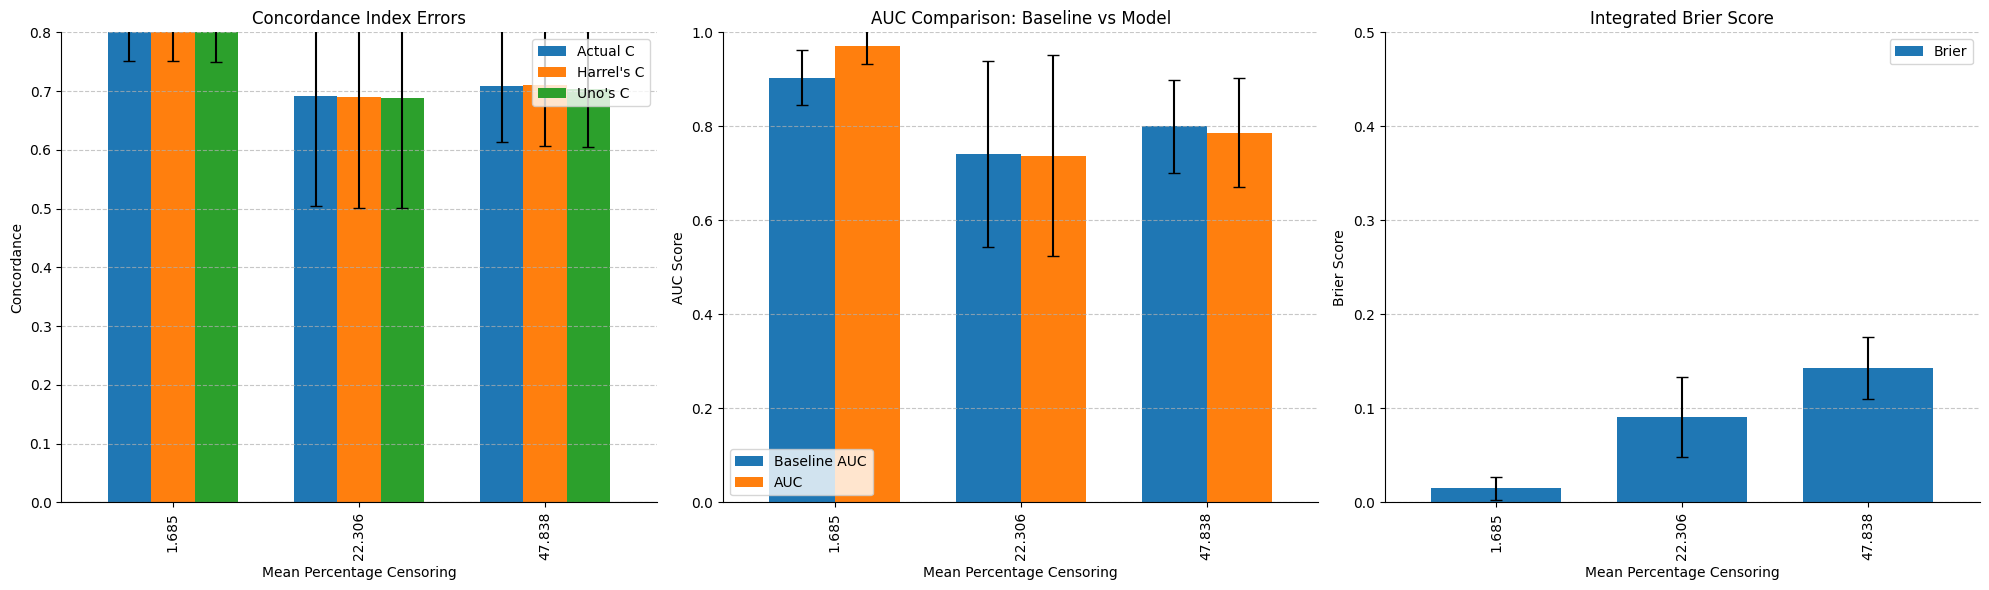

In [7]:
plot_results(results, "cph")

(<Figure size 2000x600 with 3 Axes>,
 array([<Axes: title={'center': 'Concordance Index Errors'}, xlabel='Mean Percentage Censoring', ylabel='Concordance'>,
        <Axes: title={'center': 'AUC Comparison: Baseline vs Model'}, xlabel='Mean Percentage Censoring', ylabel='AUC Score'>,
        <Axes: title={'center': 'Integrated Brier Score'}, xlabel='Mean Percentage Censoring', ylabel='Brier Score'>],
       dtype=object))

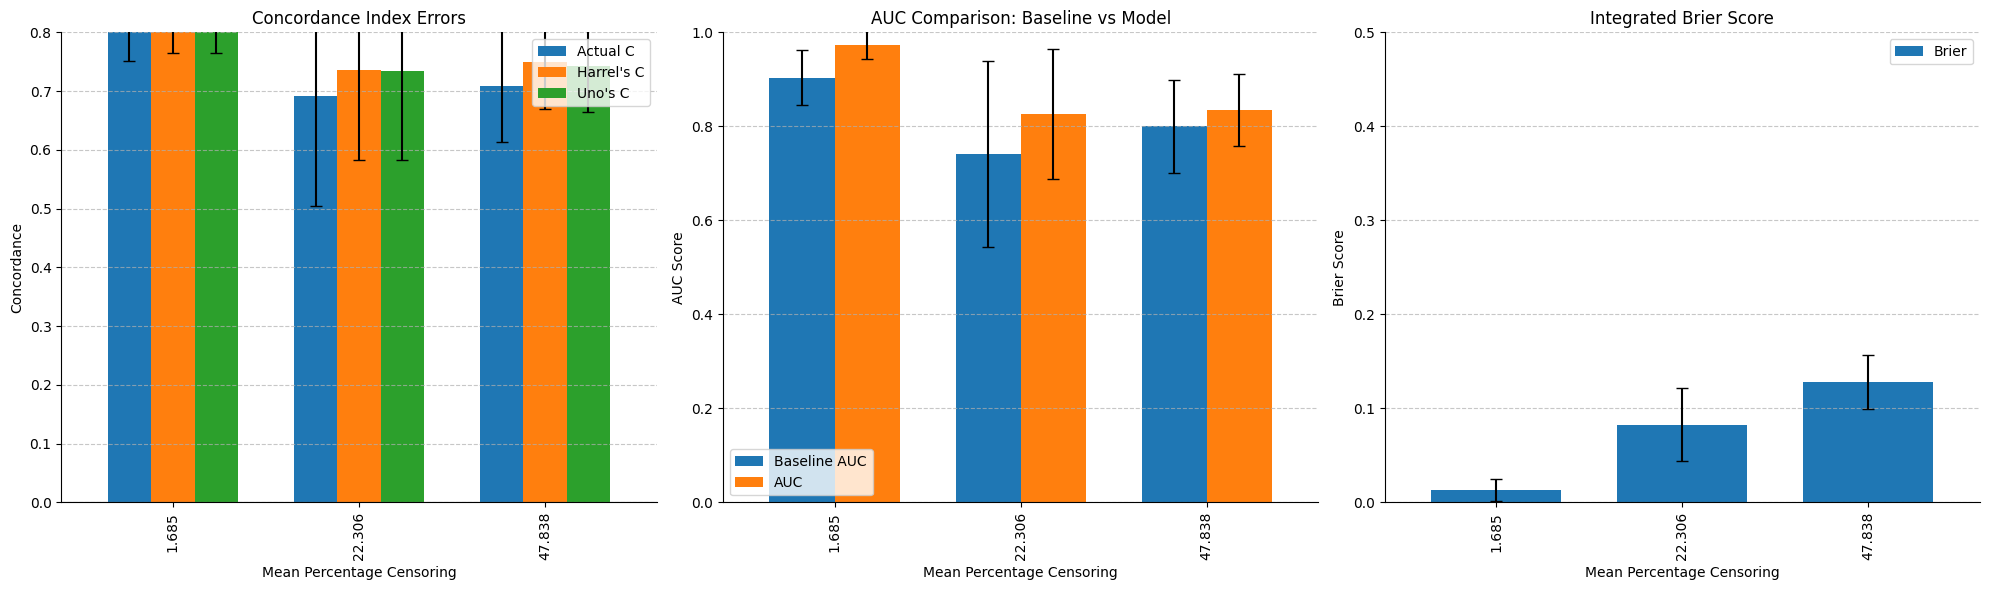

In [8]:
plot_results(results, "rsf")

(<Figure size 2000x600 with 3 Axes>,
 array([<Axes: title={'center': 'Concordance Index Errors'}, xlabel='Mean Percentage Censoring', ylabel='Concordance'>,
        <Axes: title={'center': 'AUC Comparison: Baseline vs Model'}, xlabel='Mean Percentage Censoring', ylabel='AUC Score'>,
        <Axes: title={'center': 'Integrated Brier Score'}, xlabel='Mean Percentage Censoring', ylabel='Brier Score'>],
       dtype=object))

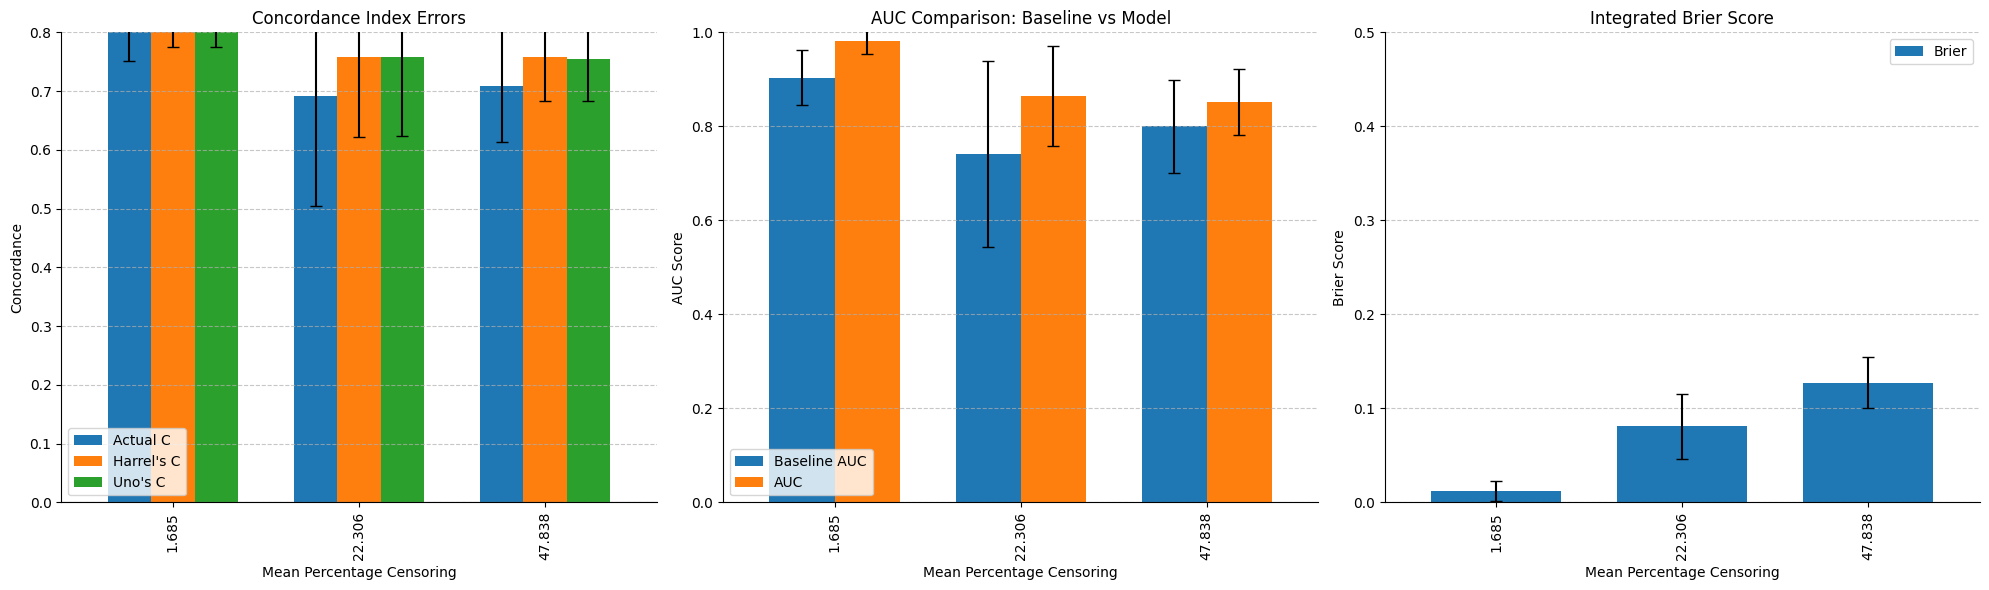

In [9]:
plot_results(results, "gbsa")